In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
from feature_collector import preprocess_data
from df_collector import df_collector
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
notebook_dir = str(Path().resolve())
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Tue Nov  5 10:39:08 2024


# initializing

In [2]:
from convsklearn import barrier_trainer, asian_trainer
filetag = 'cboe barriers'
price_name = 'barrier_price'
trainer = barrier_trainer
dataset = df_collector.cboe_spx_barriers().iloc[:,1:]
dataset = dataset[dataset[price_name]<dataset['spot_price']].dropna().reset_index(drop=True)
dataset['observed_price'] = np.maximum(dataset[price_name] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
dates = pd.Series(np.sort(dataset['date'].unique()))
dates

0      2022-04-22
1      2022-04-23
2      2022-04-26
3      2022-04-27
4      2022-04-28
          ...    
688    2024-10-11
689    2024-10-12
690    2024-10-14
691    2024-10-15
692    2024-10-16
Length: 693, dtype: object

# preprocessing

## train/test split

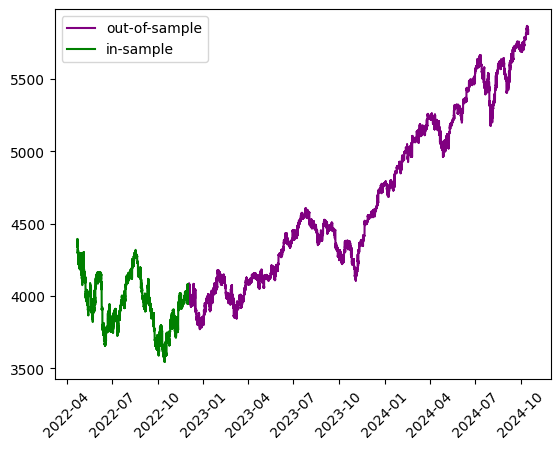

In [3]:
development_dates = dates[:len(dates)//4]
# development_dates = dates[dates<=pd.Timestamp(2008,8,1)]
test_dates = dates[~dates.isin(development_dates)]
preprocessed = preprocess_data(dataset,development_dates,test_dates,trainer)
train_test = preprocessed['train_test_arrays']
preprocessor = preprocessed['preprocessor']
train_X=train_test['train_X']
train_y=train_test['train_y']
test_X=train_test['test_X']
test_y=train_test['test_y']
train_data = preprocessed['train_data']
test_data = preprocessed['test_data']

In [ ]:
model_fit = trainer.run_dnn(preprocessor,train_X,train_y)
train_test = trainer.test_prediction_accuracy(train_data,test_data,model_fit)
train_data = train_test['train_data']
test_data = train_test['test_data']
model_fit


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001


# saving

In [ ]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    train_data.to_csv(f"{file_dir} train_data.csv")
    test_data.to_csv(f"{file_dir} test_data.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")